In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)
def add_sinks_to_model(model,mets):
    rlist = []
    for met in mets:
        rxn = cobrame.MEReaction('SK_{}'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            met:1
        })
        rxn.bounds = (0,1e-15)
        rlist.append(rxn)
    return rlist

## Setup

In [3]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
add_transport_to_model(sporeme,['atp','ctp','gtp'])

atp_c <=> atp_s
ctp_c <=> ctp_s
gtp_c <=> gtp_s


In [5]:
genes = [i + '_s' for i in list(pd.read_csv('confirmed_depletion_neighborhood.txt',header=None)[1].values)]

In [6]:
cplxs = []
for i in genes:
    m = sporeme.metabolites.get_by_id('protein_'+i)
#     c = find_complex(m)
    cplxs.append(m)
cplxs = set(cplxs)
cplxs

{<TranslatedGene protein_BSU00980_s at 0x7f212014e320>,
 <TranslatedGene protein_BSU02230_s at 0x7f211fff5320>,
 <TranslatedGene protein_BSU04520_s at 0x7f211fe69c18>,
 <TranslatedGene protein_BSU04740_s at 0x7f211fe169b0>,
 <TranslatedGene protein_BSU06420_s at 0x7f211fdabbe0>,
 <TranslatedGene protein_BSU06450_s at 0x7f211fdc2a58>,
 <TranslatedGene protein_BSU06480_s at 0x7f211fd5a470>,
 <TranslatedGene protein_BSU06490_s at 0x7f211fd5a908>,
 <TranslatedGene protein_BSU06500_s at 0x7f211fd5aa58>,
 <TranslatedGene protein_BSU06510_s at 0x7f211fd5afd0>,
 <TranslatedGene protein_BSU06530_s at 0x7f211fd716d8>,
 <TranslatedGene protein_BSU07840_s at 0x7f211fcfa3c8>,
 <TranslatedGene protein_BSU10220_s at 0x7f211fb92160>,
 <TranslatedGene protein_BSU11010_s at 0x7f211fba7ba8>,
 <TranslatedGene protein_BSU11190_s at 0x7f211fbbf0f0>,
 <TranslatedGene protein_BSU11200_s at 0x7f211fbbf630>,
 <TranslatedGene protein_BSU11210_s at 0x7f211fbbfb38>,
 <TranslatedGene protein_BSU11220_s at 0x7f211fb

In [7]:
rlist = add_sinks_to_model(sporeme,cplxs)
[(r.id,r.reaction) for r in rlist]

[('SK_protein_BSU14590_s', ' --> protein_BSU14590_s'),
 ('SK_protein_BSU23280_s', ' --> protein_BSU23280_s'),
 ('SK_protein_BSU15560_s', ' --> protein_BSU15560_s'),
 ('SK_protein_BSU15540_s', ' --> protein_BSU15540_s'),
 ('SK_protein_BSU29120_s', ' --> protein_BSU29120_s'),
 ('SK_protein_BSU27250_s', ' --> protein_BSU27250_s'),
 ('SK_protein_BSU11190_s', ' --> protein_BSU11190_s'),
 ('SK_protein_BSU06490_s', ' --> protein_BSU06490_s'),
 ('SK_protein_BSU28290_s', ' --> protein_BSU28290_s'),
 ('SK_protein_BSU23260_s', ' --> protein_BSU23260_s'),
 ('SK_protein_BSU11250_s', ' --> protein_BSU11250_s'),
 ('SK_protein_BSU32840_s', ' --> protein_BSU32840_s'),
 ('SK_protein_BSU10220_s', ' --> protein_BSU10220_s'),
 ('SK_protein_BSU33170_s', ' --> protein_BSU33170_s'),
 ('SK_protein_BSU38990_s', ' --> protein_BSU38990_s'),
 ('SK_protein_BSU32260_s', ' --> protein_BSU32260_s'),
 ('SK_protein_BSU04740_s', ' --> protein_BSU04740_s'),
 ('SK_protein_BSU15520_s', ' --> protein_BSU15520_s'),
 ('SK_prot

In [8]:
sporeme.objective = rlist

In [9]:
from bacillusme.analysis import sensitivity as ss

In [10]:
solve_me_model(sporeme,
               max_mu = 0.1,
               min_mu = .01,
               using_soplex=False,
               precision = 1e-6,
               growth_key = 'sigma',
               verbosity=2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 277.960589 seconds
Finished substituting S,lb,ub in 8.126358 seconds
Finished makeME_LP in 1.481331 seconds
Getting MINOS parameters from ME_NLP...
1 0.05 0.05 0.1 0.05 optimal
Finished substituting S,lb,ub in 7.992590 seconds
Finished makeME_LP in 1.452786 seconds
Getting MINOS parameters from ME_NLP...
2 0.05 0.05 0.07500000000000001 0.07500000000000001 1
Finished substituting S,lb,ub in 8.477287 seconds
Finished makeME_LP in 1.716203 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.07500000000000001 0.0625 optimal
Finished substituting S,lb,ub in 7.724838 seconds
Finished makeME_LP in 1.467609 seconds
Getting MINOS parameters from ME_NLP...
4 0.0625 0.0625 0.06875 0.06875 1
Finished substituting S,lb,ub in 7.441894 seconds
Finished makeME_LP in 1.446157 seconds
Getting MINOS parameters from ME_NLP...
5 0.065625 0.065625 0.06875 0.065625 optimal
Finished substituting S,lb,ub in 7.087964 s

In [11]:
pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict}).T[[r.id for r in rlist]].T.sort_values('flux').value_counts()

flux        
1.000000e-15    83
dtype: int64

## Analysis

In [ ]:
flux_responses = ss.all_flux_responses(sporeme,genes,NP=10,precision=1e-6,solution=sporeme.solution,
                       single_change_function='knockout_protein_sink',growth_key='sigma')
flux_responses.to_csv('essentiality_raw_results_neighborhood.csv')

SK_protein_BSU14590_s response (10 threads):  61%|██████▏   | 51/83 [6:22:57<10:29:47, 1180.85s/it]

In [ ]:
flux_responses.loc[[r.id for r in rlist]]

### Gene interdependence

In [ ]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [ ]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_neighborhood.csv',index_col=0)


In [ ]:
cutoff = 1e-16
translation = df.loc[[r.id for r in rlist]]
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [ ]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('SK_protein_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### Known depletions

In [ ]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

## Forward interdependence

In [27]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in fwd_name_dep:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [28]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

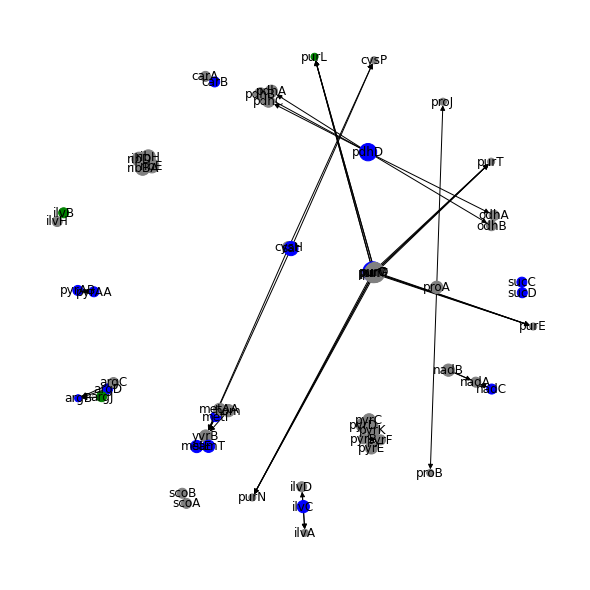

In [73]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=1e-5)
nx.draw(G,
#        pos=pos,
       with_labels = True,
       node_size=[i*50 for i in degree],
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport_neighborhood.svg',format='SVG')

#### Are any of the nodes essential in the FS?

In [161]:
summary = pd.read_csv('./essentiality_summary.csv',index_col=1)
summary.loc[[i for i in G.nodes if i in summary.index]]['FS_essential'].value_counts()

False    56
Name: FS_essential, dtype: int64

## Subgraphs

In [101]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 2 nodes
	Nodes: {'carA', 'carB'}
subgraph 1 has 4 nodes
	Nodes: {'argD', 'argC', 'argJ', 'argB'}
subgraph 2 has 9 nodes
	Nodes: {'sat', 'cysH', 'metAA', 'metE', 'samT', 'metI', 'hom', 'yvrB', 'cysP'}
subgraph 3 has 2 nodes
	Nodes: {'ilvH', 'ilvB'}
subgraph 4 has 3 nodes
	Nodes: {'ilvD', 'ilvA', 'ilvC'}
subgraph 5 has 3 nodes
	Nodes: {'nadA', 'nadC', 'nadB'}
subgraph 6 has 6 nodes
	Nodes: {'pdhA', 'pdhC', 'odhB', 'odhA', 'pdhB', 'pdhD'}
subgraph 8 has 8 nodes
	Nodes: {'purD', 'purC', 'purF', 'purT', 'purL', 'purN', 'purE', 'purM'}
subgraph 9 has 2 nodes
	Nodes: {'pyrAA', 'pyrAB'}
subgraph 13 has 2 nodes
	Nodes: {'sucD', 'sucC'}


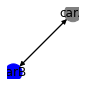

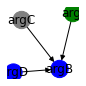

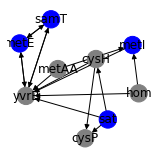

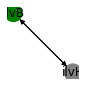

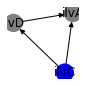

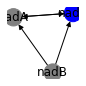

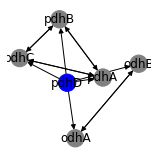

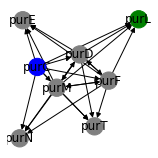

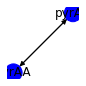

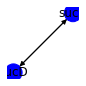

In [144]:
UG = G.to_undirected()
# extract subgraphs
sub_graphs = nx.connected_components(UG)

for i, sg in enumerate(sub_graphs):
    if not set(known_depletions) & sg: continue
    print ("subgraph {} has {} nodes".format(i, len(sg)))
    print ("\tNodes:", sg)
    SG = G.subgraph(sg)
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=2.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
    plt.savefig('figures/network_sg_{}.svg'.format(i),format='SVG')

## Forward interdependence clustergram

In [47]:
d = {}
for k,v in fwd_name_dep.items():
    d[k] = {}
    for i in v:
        d[k][i] = 0

In [48]:
kodf = pd.DataFrame.from_dict(d).fillna(1).T

In [49]:
kodf

,carA,carB,argH,adhA,argB,argD,argF,argC,argG,argJ,...,sigH,tal,sucC,sucD,trxB,thyA,udk,ydbM,yfkN,yxlA
carA,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
argH,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
adhA,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
argD,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
argF,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
udk,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
ydbM,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
yvrB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
yfkN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [55]:
set(confirmed_depletions) & set(kodf.index)

{'argJ', 'ilvB', 'purL'}

In [51]:
import seaborn as sns

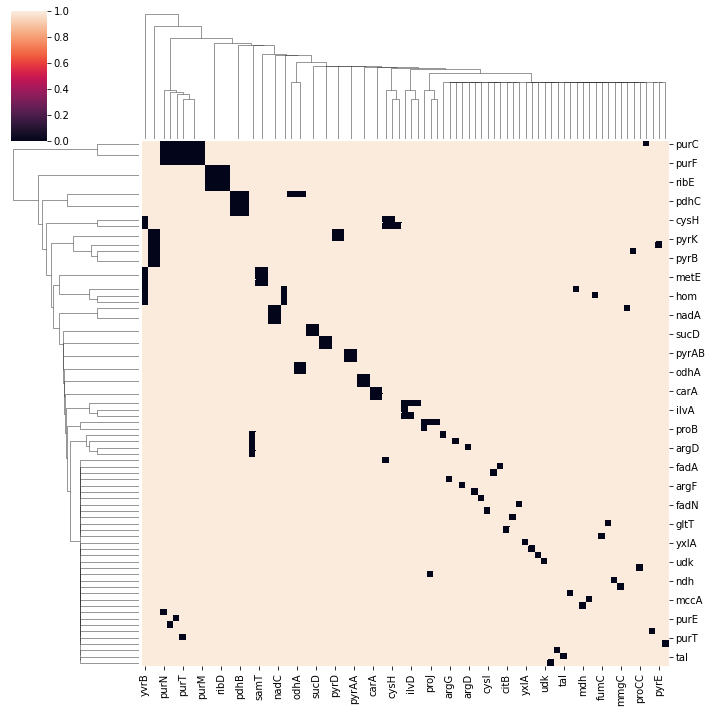

In [59]:
sns.clustermap(kodf,
              figsize=(10,10))

## One gene interdependence

In [ ]:
def get_value(k):
    return list(set(fwd_name_dep[k]) - set([k]))

def traverse_graph(k,seen = set()):
    v = get_value(k)
#     print(k,v)
    if not v:
        return seen
    for i in v:
        if i in seen:continue
        seen.add(i)
        seen = traverse_graph(i,seen=seen)
    return seen

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    seen_nodes = set()
    for i in traverse_graph(gene):
        if i in seen_nodes: continue
        seen_nodes.add(i)
        dep_genes = fwd_name_dep[i]
        for j in dep_genes:
            print(i,j)
            if j==gene: continue
            G.add_edge(i,j)
    return G

In [ ]:
gene = 'argD'
G = get_graph_from_gene(gene)
G.nodes

In [ ]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')   
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

In [ ]:
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_{}.svg'.format(gene),format='SVG')